In [2]:
!pip install pandas_profiling

  Stored in directory: C:\Users\ksuha\AppData\Local\pip\Cache\wheels\ce\c7\f1\dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Stored in directory: C:\Users\ksuha\AppData\Local\pip\Cache\wheels\43\07\ac\7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Stored in directory: C:\Users\ksuha\AppData\Local\pip\Cache\wheels\b0\b2\96\2074eee7dbf7b7df69d004c9b6ac4e32dad04fb7666cf943bd
Successfully built pandas-profiling htmlmin confuse


In [3]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import pandas_profiling as pp

Importing our main application dataset which contains loan application ID and relevant details

In [4]:
application_test = pd.read_csv("application_test.csv")

In [5]:
application_train = pd.read_csv("application_train.csv")

Bureau dataset contains information about the previous credit of the customer taken from other insitutions

In [6]:
bureau = pd.read_csv("bureau.csv")

In [7]:
bureau_balance = pd.read_csv("bureau_balance.csv")

First let's look at application data, we merge the application train and test to obtain one single dataset. 

In [8]:
application_train['set'] = 'train'
application_test['set'] = 'test'
application_test["TARGET"] = np.nan

# Append the dataframes
app = application_train.append(application_test, ignore_index = True, sort = False)

In [9]:
len(app)

356255

Checking the total loan application IDs for which we don't have information from bureau data

In [10]:
unique_IDs_bureau = pd.DataFrame(bureau.SK_ID_CURR.unique())
unique_IDs_bureau.columns = ["SK_ID_CURR_bur"]
unique_IDs_application = pd.DataFrame(app.SK_ID_CURR.unique())
unique_IDs_application.columns = ["SK_ID_CURR_app"]

In [11]:
IDs_bureau_app = unique_IDs_application.merge(unique_IDs_bureau, left_on = "SK_ID_CURR_app", right_on = "SK_ID_CURR_bur",how = "left")
IDs_bureau_app.head()

,SK_ID_CURR_app,SK_ID_CURR_bur
0,100002,100002.0
1,100003,100003.0
2,100004,100004.0
3,100006,NaN
4,100007,100007.0


There are 50 k loan application IDs for which we don't have information from bureau

In [12]:
sum(IDs_bureau_app.SK_ID_CURR_bur.isnull())

50444

In [13]:
app.SK_ID_CURR.nunique()

356255

14.15% of the loan application IDs do not have bureau data, we will have to do missing value treatment for them.

In [14]:
((sum(IDs_bureau_app.SK_ID_CURR_bur.isnull()))/app.SK_ID_CURR.nunique())*100

14.159520568132377

In [15]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Bureau data has all information about the previous credit: categorical fields like status of the loan, type of credit and currency type. It also has some numerical variables like total no of times overdue, credit overdue, total no of days before which credit was taken. 

There are multiple previous credits for one loan application ID. Since, our final dataset should be at a loan application ID level there is a need to transform and aggregate these variables.

For numerical variables, we will look at the mean, min, max and sum of each variable. Defining a function to get mean, min, max and sum for numeric variables.

In [16]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [17]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')

C:\Users\ksuha\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_mean,...,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,-735.000000,-49,-1572,-5145,0.0,0,0,0,82.428571,...,0.0,0.0,-93.142857,-6,-155,-652,3545.357143,10822.5,0.0,24817.5
1,100002,-874.000000,-103,-1437,-6992,0.0,0,0,0,-349.000000,...,0.0,0.0,-499.875000,-7,-1185,-3999,0.000000,0.0,0.0,0.0
2,100003,-1400.750000,-606,-2586,-5603,0.0,0,0,0,-544.500000,...,0.0,0.0,-816.000000,-43,-2131,-3264,NaN,NaN,NaN,0.0
3,100004,-867.000000,-408,-1326,-1734,0.0,0,0,0,-488.500000,...,0.0,0.0,-532.000000,-382,-682,-1064,NaN,NaN,NaN,0.0
4,100005,-190.666667,-62,-373,-572,0.0,0,0,0,439.333333,...,0.0,0.0,-54.333333,-11,-121,-163,1420.500000,4261.5,0.0,4261.5


In [19]:
bureau_agg_new.columns

Index(['SK_ID_CURR', 'bureau_DAYS_CREDIT_mean', 'bureau_DAYS_CREDIT_max',
       'bureau_DAYS_CREDIT_min', 'bureau_DAYS_CREDIT_sum',
       'bureau_CREDIT_DAY_OVERDUE_mean', 'bureau_CREDIT_DAY_OVERDUE_max',
       'bureau_CREDIT_DAY_OVERDUE_min', 'bureau_CREDIT_DAY_OVERDUE_sum',
       'bureau_DAYS_CREDIT_ENDDATE_mean', 'bureau_DAYS_CREDIT_ENDDATE_max',
       'bureau_DAYS_CREDIT_ENDDATE_min', 'bureau_DAYS_CREDIT_ENDDATE_sum',
       'bureau_DAYS_ENDDATE_FACT_mean', 'bureau_DAYS_ENDDATE_FACT_max',
       'bureau_DAYS_ENDDATE_FACT_min', 'bureau_DAYS_ENDDATE_FACT_sum',
       'bureau_AMT_CREDIT_MAX_OVERDUE_mean',
       'bureau_AMT_CREDIT_MAX_OVERDUE_max',
       'bureau_AMT_CREDIT_MAX_OVERDUE_min',
       'bureau_AMT_CREDIT_MAX_OVERDUE_sum', 'bureau_CNT_CREDIT_PROLONG_mean',
       'bureau_CNT_CREDIT_PROLONG_max', 'bureau_CNT_CREDIT_PROLONG_min',
       'bureau_CNT_CREDIT_PROLONG_sum', 'bureau_AMT_CREDIT_SUM_mean',
       'bureau_AMT_CREDIT_SUM_max', 'bureau_AMT_CREDIT_SUM_min',
       

In [20]:
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_mean,...,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,-735.000000,-49,-1572,-5145,0.0,0,0,0,82.428571,...,0.0,0.0,-93.142857,-6,-155,-652,3545.357143,10822.5,0.0,24817.5
1,100002,-874.000000,-103,-1437,-6992,0.0,0,0,0,-349.000000,...,0.0,0.0,-499.875000,-7,-1185,-3999,0.000000,0.0,0.0,0.0
2,100003,-1400.750000,-606,-2586,-5603,0.0,0,0,0,-544.500000,...,0.0,0.0,-816.000000,-43,-2131,-3264,NaN,NaN,NaN,0.0
3,100004,-867.000000,-408,-1326,-1734,0.0,0,0,0,-488.500000,...,0.0,0.0,-532.000000,-382,-682,-1064,NaN,NaN,NaN,0.0
4,100005,-190.666667,-62,-373,-572,0.0,0,0,0,439.333333,...,0.0,0.0,-54.333333,-11,-121,-163,1420.500000,4261.5,0.0,4261.5


There are categorical variables in the data. For example, for one loan application ID in our data we will have multiple instances of the CREDIT TYPE. These are categorical variables, we need to get for every loan application type the total no of loan of type consumer credit, credit card, mortgage ,etc.

In [21]:
bureau.CREDIT_TYPE.unique()

array(['Consumer credit', 'Credit card', 'Mortgage', 'Car loan',
       'Microloan', 'Loan for working capital replenishment',
       'Loan for business development', 'Real estate loan',
       'Unknown type of loan', 'Another type of loan',
       'Cash loan (non-earmarked)', 'Loan for the purchase of equipment',
       'Mobile operator loan', 'Interbank credit',
       'Loan for purchase of shares (margin lending)'], dtype=object)

Handling categorical variables: Creating dummy varible for each values in the categorical column. For example - If status column has four values : Active, Bad Debt, Closed and Sold. We will create four columns and populate values for these.

In [22]:
bureau_cat = pd.get_dummies(bureau.select_dtypes('object'))
bureau_cat['SK_ID_CURR'] = bureau['SK_ID_CURR']
bureau_cat.SK_ID_CURR.count()

1716428

In [23]:
bureau_cat.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


Since our final data should be at a loan application ID level, we aggregate the columns created above (We calculate the sum)

In [24]:
bureau_cat_grouped = bureau_cat.groupby('SK_ID_CURR').agg(['sum'])
bureau_cat_grouped.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,...,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0,4,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100002,2,0,6,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100003,1,0,3,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100004,0,0,2,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100005,2,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in bureau_cat_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
bureau_cat_grouped.columns = columns

bureau_cat_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Sold_count,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 4_count,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Car loan_count,...,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Unknown type of loan_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0,4,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100002,2,0,6,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100003,1,0,3,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100004,0,0,2,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100005,2,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Merging the categorical and numerical variables to create our final bureau dataset

In [26]:
bureau_vf =  bureau_agg_new.merge(bureau_cat_grouped, on = "SK_ID_CURR")

Checking if the total no of bureau IDs are unique

In [27]:
bureau_vf.SK_ID_CURR.count()

305811

In [28]:
bureau_vf.SK_ID_CURR.nunique()

305811

Checking the total no of loan application IDs present in the initial bureau dataset. This matches the total no of loan application IDs present in the final bureau dataset.

In [29]:
bureau.SK_ID_CURR.nunique()

305811

In [30]:
bureau_vf.head(100).to_csv("bureau_sample_vf.csv",index = False)

Some Exploratory Data Analysis on Application data

In [31]:
app.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'set'],
      dtype='object', length=123)

In [32]:
app_target = pd.DataFrame(app.TARGET.value_counts())
app_target =  app_target.reset_index()
app_target.columns = ["Target","Total Times"]
app_target.loc[app_target.Target == 0.0,"Status"] = "Accepted"
app_target.loc[app_target.Target == 1.0,"Status"] = "Rejected"
app_target = app_target.drop("Target", axis = 1)

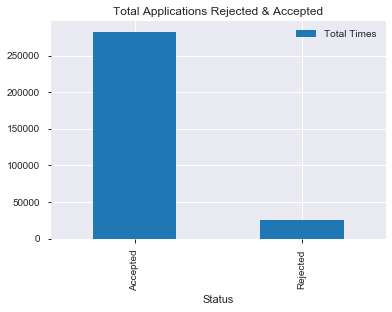

In [33]:
app_target.plot.bar(title = "Total Applications Rejected & Accepted", x = "Status")

In [34]:
app_target.columns

Index(['Total Times', 'Status'], dtype='object')

In [35]:
app.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'set'],
      dtype='object', length=123)

In [36]:
bureau_balance[bureau_balance.SK_ID_BUREAU == 5715448].head(100)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [37]:
bureau_balance.STATUS.unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [38]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [39]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_1_count,bureau_balance_STATUS_2_count,bureau_balance_STATUS_3_count,bureau_balance_STATUS_4_count,bureau_balance_STATUS_5_count,bureau_balance_STATUS_C_count,bureau_balance_STATUS_X_count
SK_ID_BUREAU,,,,,,,,
5001709,0,0,0,0,0,0,86,11
5001710,5,0,0,0,0,0,48,30
5001711,3,0,0,0,0,0,0,1
5001712,10,0,0,0,0,0,9,0
5001713,0,0,0,0,0,0,0,22


In [40]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

C:\Users\ksuha\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,-48.0,0,-96,-4656
1,5001710,-41.0,0,-82,-3403
2,5001711,-1.5,0,-3,-6
3,5001712,-9.0,0,-18,-171
4,5001713,-10.5,0,-21,-231


In [41]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_1_count,bureau_balance_STATUS_2_count,bureau_balance_STATUS_3_count,bureau_balance_STATUS_4_count,bureau_balance_STATUS_5_count,bureau_balance_STATUS_C_count,bureau_balance_STATUS_X_count
SK_ID_BUREAU,,,,,,,,
5001709,0,0,0,0,0,0,86,11
5001710,5,0,0,0,0,0,48,30
5001711,3,0,0,0,0,0,0,1
5001712,10,0,0,0,0,0,9,0
5001713,0,0,0,0,0,0,0,22


In [42]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_1_count,bureau_balance_STATUS_2_count,bureau_balance_STATUS_3_count,bureau_balance_STATUS_4_count,bureau_balance_STATUS_5_count,bureau_balance_STATUS_C_count,bureau_balance_STATUS_X_count,SK_ID_CURR
0,5001709,-48.0,0,-96,-4656,0,0,0,0,0,0,86,11,NaN
1,5001710,-41.0,0,-82,-3403,5,0,0,0,0,0,48,30,162368.0
2,5001711,-1.5,0,-3,-6,3,0,0,0,0,0,0,1,162368.0
3,5001712,-9.0,0,-18,-171,10,0,0,0,0,0,9,0,162368.0
4,5001713,-10.5,0,-21,-231,0,0,0,0,0,0,0,22,150635.0


In [43]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_min_mean,...,client_bureau_balance_STATUS_5_count_min,client_bureau_balance_STATUS_5_count_sum,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_sum,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum
0,100001.0,-11.785714,-0.5,-25.5,-82.5,0.0,0,0,0,-23.571429,...,0,0.0,15.714286,44,0,110.0,4.285714,9,0,30.0
1,100002.0,-21.875000,-1.5,-39.5,-175.0,-15.5,0,-32,-124,-28.250000,...,0,0.0,2.875000,13,0,23.0,1.875000,3,0,15.0
2,100005.0,-3.000000,-1.0,-6.0,-9.0,0.0,0,0,0,-6.000000,...,0,0.0,1.666667,5,0,5.0,0.666667,1,0,2.0
3,100010.0,-46.000000,-19.5,-72.5,-92.0,-28.5,-2,-55,-57,-63.500000,...,0,0.0,26.000000,26,26,52.0,0.000000,0,0,0.0
4,100013.0,-28.250000,-19.5,-34.0,-113.0,0.0,0,0,0,-56.500000,...,0,0.0,25.750000,44,0,103.0,10.250000,40,0,41.0


In [44]:
bureau_balance_by_client.SK_ID_CURR.nunique()

134542

In [45]:
bureau_vf.SK_ID_CURR.nunique()

305811

In [46]:
app.SK_ID_CURR.nunique()

356255

63% of the loan application IDs do not have bureau balance data. Imputing values for 63% does not make sense. Therefore, we go ahead and remove these dataset.

In [47]:
((356255-134542)/356255)*100

62.23435460554939

In [48]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [49]:
bureau.AMT_CREDIT_MAX_OVERDUE.describe()

count    5.919400e+05
mean     3.825418e+03
std      2.060316e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.159872e+08
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

In [50]:
# Missing values statistics
missing_values = missing_values_table(bureau_vf)
missing_values

Your selected dataframe has 72 columns.
There are 21 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,187587,61.3
bureau_AMT_ANNUITY_max,187587,61.3
bureau_AMT_ANNUITY_mean,187587,61.3
bureau_AMT_CREDIT_MAX_OVERDUE_mean,92840,30.4
bureau_AMT_CREDIT_MAX_OVERDUE_max,92840,30.4
bureau_AMT_CREDIT_MAX_OVERDUE_min,92840,30.4
bureau_DAYS_ENDDATE_FACT_mean,37656,12.3
bureau_DAYS_ENDDATE_FACT_max,37656,12.3
bureau_DAYS_ENDDATE_FACT_min,37656,12.3
bureau_AMT_CREDIT_SUM_LIMIT_mean,25308,8.3


In [51]:
bureau_vf.columns

Index(['SK_ID_CURR', 'bureau_DAYS_CREDIT_mean', 'bureau_DAYS_CREDIT_max',
       'bureau_DAYS_CREDIT_min', 'bureau_DAYS_CREDIT_sum',
       'bureau_CREDIT_DAY_OVERDUE_mean', 'bureau_CREDIT_DAY_OVERDUE_max',
       'bureau_CREDIT_DAY_OVERDUE_min', 'bureau_CREDIT_DAY_OVERDUE_sum',
       'bureau_DAYS_CREDIT_ENDDATE_mean', 'bureau_DAYS_CREDIT_ENDDATE_max',
       'bureau_DAYS_CREDIT_ENDDATE_min', 'bureau_DAYS_CREDIT_ENDDATE_sum',
       'bureau_DAYS_ENDDATE_FACT_mean', 'bureau_DAYS_ENDDATE_FACT_max',
       'bureau_DAYS_ENDDATE_FACT_min', 'bureau_DAYS_ENDDATE_FACT_sum',
       'bureau_AMT_CREDIT_MAX_OVERDUE_mean',
       'bureau_AMT_CREDIT_MAX_OVERDUE_max',
       'bureau_AMT_CREDIT_MAX_OVERDUE_min',
       'bureau_AMT_CREDIT_MAX_OVERDUE_sum', 'bureau_CNT_CREDIT_PROLONG_mean',
       'bureau_CNT_CREDIT_PROLONG_max', 'bureau_CNT_CREDIT_PROLONG_min',
       'bureau_CNT_CREDIT_PROLONG_sum', 'bureau_AMT_CREDIT_SUM_mean',
       'bureau_AMT_CREDIT_SUM_max', 'bureau_AMT_CREDIT_SUM_min',
       

In [52]:
bureau_vf =  bureau_vf.drop(columns = ["bureau_AMT_ANNUITY_max","bureau_AMT_ANNUITY_mean","bureau_AMT_ANNUITY_min"])

In [53]:
bureau[bureau.AMT_CREDIT_MAX_OVERDUE.isnull() == True]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
11,162297,5714473,Closed,currency 1,-2456,0,-629.0,-825.0,NaN,0,675000.0,0.0,0.0,0.0,Consumer credit,-706,NaN
14,238881,5714482,Closed,currency 1,-318,0,-187.0,-187.0,NaN,0,0.0,0.0,0.0,0.0,Credit card,-185,NaN
15,238881,5714484,Closed,currency 1,-2911,0,-2607.0,-2604.0,NaN,0,48555.0,NaN,NaN,0.0,Consumer credit,-2601,NaN
16,238881,5714485,Closed,currency 1,-2148,0,-1595.0,-987.0,NaN,0,135000.0,NaN,NaN,0.0,Consumer credit,-984,NaN
17,238881,5714486,Active,currency 1,-381,0,NaN,NaN,NaN,0,450000.0,520920.0,NaN,0.0,Consumer credit,-4,NaN
18,238881,5714487,Active,currency 1,-95,0,1720.0,NaN,NaN,0,67500.0,8131.5,NaN,0.0,Credit card,-7,NaN


In [54]:
bureau.AMT_CREDIT_MAX_OVERDUE.describe()

count    5.919400e+05
mean     3.825418e+03
std      2.060316e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.159872e+08
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

Let us look at the application data, we have many categorical variables. We need to encode them as dummy variables in the data

In [55]:
app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,set
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [56]:
app_categorical = count_categorical(app, group_var = 'SK_ID_CURR', df_name = 'app')
app_categorical.columns

Index(['app_NAME_CONTRACT_TYPE_Cash loans_count',
       'app_NAME_CONTRACT_TYPE_Revolving loans_count',
       'app_CODE_GENDER_F_count', 'app_CODE_GENDER_M_count',
       'app_CODE_GENDER_XNA_count', 'app_FLAG_OWN_CAR_N_count',
       'app_FLAG_OWN_CAR_Y_count', 'app_FLAG_OWN_REALTY_N_count',
       'app_FLAG_OWN_REALTY_Y_count', 'app_NAME_TYPE_SUITE_Children_count',
       ...
       'app_WALLSMATERIAL_MODE_Mixed_count',
       'app_WALLSMATERIAL_MODE_Monolithic_count',
       'app_WALLSMATERIAL_MODE_Others_count',
       'app_WALLSMATERIAL_MODE_Panel_count',
       'app_WALLSMATERIAL_MODE_Stone, brick_count',
       'app_WALLSMATERIAL_MODE_Wooden_count',
       'app_EMERGENCYSTATE_MODE_No_count', 'app_EMERGENCYSTATE_MODE_Yes_count',
       'app_set_test_count', 'app_set_train_count'],
      dtype='object', length=142)

In [57]:
app.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,307511.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,...,356255.000000,356255.000000,356255.000000,356255.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000
mean,278128.000000,0.080729,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,...,0.007231,0.000514,0.000438,0.000289,0.005808,0.006281,0.029995,0.231697,0.304399,1.911564
std,102842.104413,0.272419,0.720378,2.235068e+05,3.986237e+05,14732.808190,3.660650e+05,0.013915,4358.803980,141705.532576,...,0.084726,0.022659,0.020921,0.017001,0.079736,0.104250,0.191374,0.855949,0.786915,1.865338
min,100001.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000253,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189064.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,0.010006,-19676.000000,-2781.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278128.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,0.018850,-15755.000000,-1224.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367191.500000,0.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,0.028663,-12425.000000,-290.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7338.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [58]:
app.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'set'],
      dtype='object', length=123)

In [59]:
app_cat_rem = app.drop(columns  = ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE",
"NAME_INCOME_TYPE",
"NAME_EDUCATION_TYPE",
"NAME_FAMILY_STATUS",
"NAME_HOUSING_TYPE",
"OCCUPATION_TYPE",
"WEEKDAY_APPR_PROCESS_START",
"ORGANIZATION_TYPE",
"FONDKAPREMONT_MODE",
"HOUSETYPE_MODE",
"TOTALAREA_MODE",
"WALLSMATERIAL_MODE",
"EMERGENCYSTATE_MODE"])


In [60]:
app_with_cat =  app_cat_rem.merge(app_categorical, on = 'SK_ID_CURR')
len(app_with_cat)
app_with_cat = app_with_cat.drop(columns = ["app_set_test_count","app_set_train_count"])
app_set = app[["set","SK_ID_CURR"]]
app_with_cat = app_with_cat.merge(app_set, on = "SK_ID_CURR")

In [61]:
len(app_with_cat)

356255

In [62]:
app_with_cat.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,app_WALLSMATERIAL_MODE_Block_count,app_WALLSMATERIAL_MODE_Mixed_count,app_WALLSMATERIAL_MODE_Monolithic_count,app_WALLSMATERIAL_MODE_Others_count,app_WALLSMATERIAL_MODE_Panel_count,"app_WALLSMATERIAL_MODE_Stone, brick_count",app_WALLSMATERIAL_MODE_Wooden_count,app_EMERGENCYSTATE_MODE_No_count,app_EMERGENCYSTATE_MODE_Yes_count,set_y
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,1,0,1,0,train
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,1,0,0,0,0,0,0,1,0,train
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,train
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,train
4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,train


In [63]:
app_set.head()

,set,SK_ID_CURR
0,train,100002
1,train,100003
2,train,100004
3,train,100006
4,train,100007


In [64]:
app_with_bur = app_with_cat.merge(bureau_vf,  on = "SK_ID_CURR", how = "left")

In [65]:
# Missing values statistics
missing_values = missing_values_table(app_with_bur)
missing_values = pd.DataFrame(missing_values)

Your selected dataframe has 315 columns.
There are 129 columns that have missing values.


In [66]:
missing_values.to_csv("missing_values.csv")

In [67]:
len(app_with_bur)

356255

In [68]:
len(app)

356255

In [69]:
app_with_bur.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'CREDIT_TYPE_Interbank credit_count',
       'CREDIT_TYPE_Loan for business development_count',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)_count',
       'CREDIT_TYPE_Loan for the purchase of equipment_count',
       'CREDIT_TYPE_Loan for working capital replenishment_count',
       'CREDIT_TYPE_Microloan_count', 'CREDIT_TYPE_Mobile operator loan_count',
       'CREDIT_TYPE_Mortgage_count', 'CREDIT_TYPE_Real estate loan_count',
       'CREDIT_TYPE_Unknown type of loan_count'],
      dtype='object', length=315)

In [70]:
# Missing values statistics
missing_values = missing_values_table(app)
missing_values = pd.DataFrame(missing_values)

Your selected dataframe has 123 columns.
There are 68 columns that have missing values.


In [71]:
missing_values

,Missing Values,% of Total Values
COMMONAREA_AVG,248360,69.7
COMMONAREA_MEDI,248360,69.7
COMMONAREA_MODE,248360,69.7
NONLIVINGAPARTMENTS_MEDI,246861,69.3
NONLIVINGAPARTMENTS_MODE,246861,69.3
NONLIVINGAPARTMENTS_AVG,246861,69.3
FONDKAPREMONT_MODE,243092,68.2
LIVINGAPARTMENTS_MEDI,242979,68.2
LIVINGAPARTMENTS_AVG,242979,68.2
LIVINGAPARTMENTS_MODE,242979,68.2


In [72]:
# Missing values statistics
missing_values = missing_values_table(app_with_bur)
missing_values

Your selected dataframe has 315 columns.
There are 129 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,248360,69.7
COMMONAREA_AVG,248360,69.7
COMMONAREA_MEDI,248360,69.7
NONLIVINGAPARTMENTS_MODE,246861,69.3
NONLIVINGAPARTMENTS_AVG,246861,69.3
NONLIVINGAPARTMENTS_MEDI,246861,69.3
LIVINGAPARTMENTS_MEDI,242979,68.2
LIVINGAPARTMENTS_MODE,242979,68.2
LIVINGAPARTMENTS_AVG,242979,68.2
FLOORSMIN_MEDI,241108,67.7


In [73]:
app_with_bur.TARGET

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        1.0
27        0.0
28        0.0
29        0.0
         ... 
356225    NaN
356226    NaN
356227    NaN
356228    NaN
356229    NaN
356230    NaN
356231    NaN
356232    NaN
356233    NaN
356234    NaN
356235    NaN
356236    NaN
356237    NaN
356238    NaN
356239    NaN
356240    NaN
356241    NaN
356242    NaN
356243    NaN
356244    NaN
356245    NaN
356246    NaN
356247    NaN
356248    NaN
356249    NaN
356250    NaN
356251    NaN
356252    NaN
356253    NaN
356254    NaN
Name: TARGET, Length: 356255, dtype: float64

In [74]:
len(app)

356255

In [75]:
app_with_bur.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Unknown type of loan_count
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
previous=pd.read_csv('previous_application_agg.csv',index_col=0)

In [77]:
previous.head()

,SK_ID_CURR,AGG_AMT_ANNUITY_count,AGG_AMT_ANNUITY_mean,AGG_AMT_ANNUITY_max,AGG_AMT_ANNUITY_min,AGG_AMT_ANNUITY_sum,AGG_AMT_APPLICATION_count,AGG_AMT_APPLICATION_mean,AGG_AMT_APPLICATION_max,AGG_AMT_APPLICATION_min,...,AGG_CODE_REJECT_REASON_XAP_mean,AGG_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,AGG_NAME_PORTFOLIO_POS_sum,AGG_NAME_CONTRACT_TYPE_Consumer loans_sum,AGG_NAME_CASH_LOAN_PURPOSE_XAP_sum,AGG_NAME_PRODUCT_TYPE_XNA_sum,AGG_NAME_CONTRACT_STATUS_Approved_sum,AGG_CODE_REJECT_REASON_XAP_sum,AGG_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,AGG_NAME_CONTRACT_TYPE_Cash loans_count
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,...,1.0,1.0,1,1,1,1,1,1,1,1
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,...,1.0,1.0,1,1,1,1,1,1,1,1
2,100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,...,1.0,1.0,2,2,2,2,3,3,3,3
3,100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,...,1.0,1.0,1,1,1,1,1,1,1,1
4,100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,...,1.0,1.0,1,1,1,2,1,2,2,2


In [78]:
app_semi=app_with_bur.merge(previous,on='SK_ID_CURR',how='left')

In [79]:
app_with_bur.shape

(356255, 315)

In [83]:
pos=pd.read_csv('POS_CASH_BALANCE_agg.csv',index_col=0)

In [85]:
pos.head()

,SK_ID_CURR,AGG_MONTHS_BALANCE_count,AGG_MONTHS_BALANCE_mean,AGG_MONTHS_BALANCE_max,AGG_MONTHS_BALANCE_min,AGG_MONTHS_BALANCE_sum,AGG_CNT_INSTALMENT_count,AGG_CNT_INSTALMENT_mean,AGG_CNT_INSTALMENT_max,AGG_CNT_INSTALMENT_min,...,AGG_NAME_CONTRACT_STATUS_Returned to the store_mean,AGG_NAME_CONTRACT_STATUS_Returned to the store_sum,AGG_NAME_CONTRACT_STATUS_Signed_mean,AGG_NAME_CONTRACT_STATUS_Signed_sum,AGG_NAME_CONTRACT_STATUS_Completed_mean,AGG_NAME_CONTRACT_STATUS_Active_mean,AGG_NAME_CONTRACT_STATUS_Completed_sum,AGG_NAME_CONTRACT_STATUS_Active_sum,AGG_NAME_CONTRACT_STATUS_Active_count,previous_loan_counts
0,100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,...,0.0,0,0.000000,0,0.222222,0.777778,2,7.0,9,9
1,100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,...,0.0,0,0.000000,0,0.000000,1.000000,0,19.0,19,19
2,100003,28,-43.785714,-18,-77,-1226,28,10.107143,12.0,6.0,...,0.0,0,0.000000,0,0.071429,0.928571,2,26.0,28,28
3,100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,...,0.0,0,0.000000,0,0.250000,0.750000,1,3.0,4,4
4,100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,...,0.0,0,0.090909,1,0.090909,0.818182,1,9.0,11,11


In [86]:
pos=app_semi.merge(pos,on='SK_ID_CURR',how='left')

In [88]:
pos.to_csv('merged_data.csv')